Import some counts of tweets I collected using the `twarc filter demdebate`.

In [277]:
import pandas

demdebate = pandas.read_csv('data/demdebate.csv', parse_dates=['time'])
demdebate.head()

,time,tweets
0,2019-09-13 00:00:00,30
1,2019-09-13 00:00:01,12
2,2019-09-13 00:00:02,11
3,2019-09-13 00:00:03,9
4,2019-09-13 00:00:04,6


The granularity of a second is too fine for visualization. So let's try aggregating the counts by minute:

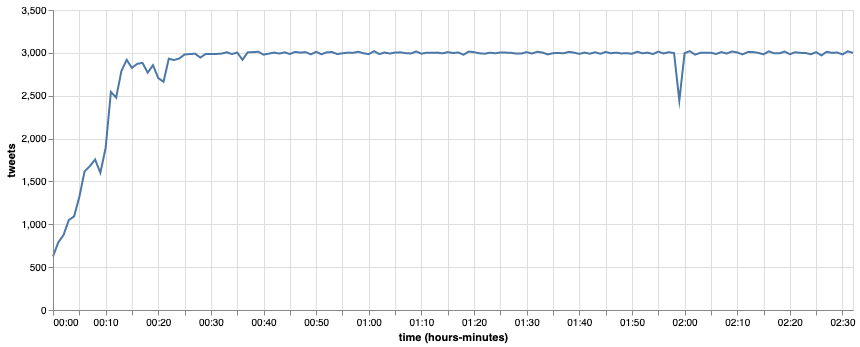

In [282]:
import altair
altair.renderers.enable('notebook')

demdebate = demdebate.resample("1Min", on="time").sum().reset_index()
altair.Chart(demdebate, width=800).mark_line().encode(x='hoursminutes(time):T', y='tweets:Q')

This graph plainly shows that we hit a maximum throughput of about 3,000 tweets per minute. It also shows that Twitter closed our filter stream around 2AM UTC, which twarc caught and quickly reopened its connection. But it lost a few tweets as a result.

## Dropped Tweets

Legend has it (based on [old documentation](https://archive.is/X1XUZ#selection-781.0-799.212)) that Twitter's filter stream API will never deliver more than 1% of the total total tweets in a given second. Any tweets exceeding this amount will be "rate limited" or dropped.

> If you're using the filter feature of the Streaming API, you'll be streamed Y tweets per "streaming second" that match your criteria, where Y tweets can never exceed 1% of X public tweets in the firehose during that same "streaming second." If there are more tweets that would match your criteria, you'll be streamed a rate limit message indicating how many tweets fell outside of 1%. 

Whether this legend is still true or not we can be sure that an event like the Democratic debate will be trigger any rate limits that might exist. In fact Twitter's [status/filter](https://developer.twitter.com/en/docs/tweets/filter-realtime/api-reference/post-statuses-filter.html) API endpoint will emit [Limit Notices](https://developer.twitter.com/en/docs/tweets/filter-realtime/guides/streaming-message-types) which are delivered right along with the tweets on the stream, and indicate how many tweets were undelivered.

> These messages indicate that a filtered stream has matched more Tweets than its current rate limit allows to be delivered. Limit notices contain a total count of the number of undelivered Tweets since the connection was opened, making them useful for tracking counts of track terms, for example. Note that the counts do not specify which filter predicates undelivered messages matched.

```json
{
  "limit": {
    "track":1234
  }
}
```

twarc actually logs these messages as it encounters them. For example you will see messages like this in your log if your data collection is being limited:

```
2019-09-13 00:13:08,866 WARNING 51 tweets undelivered
```

So we can actually parse the log file and extract these counts to see how many tweets were dropped. Then we can add them to our graph to see if we can get a better sense of the volume of tweets.




In [279]:
dropped = pandas.read_csv('data/demdebate-dropped.csv', parse_dates=['time'])
dropped = dropped.resample("1Min", on="time").sum().reset_index()

dropped.head(15)

,time,tweets
0,2019-09-13 00:11:00,20
1,2019-09-13 00:12:00,15
2,2019-09-13 00:13:00,105
3,2019-09-13 00:14:00,348
4,2019-09-13 00:15:00,226
5,2019-09-13 00:16:00,139
6,2019-09-13 00:17:00,211
7,2019-09-13 00:18:00,135
8,2019-09-13 00:19:00,205
9,2019-09-13 00:20:00,128


The tweets didn't start getting dropped until about 11 minutes into the debate, and then they continued to be dropped at varying rates until the end.

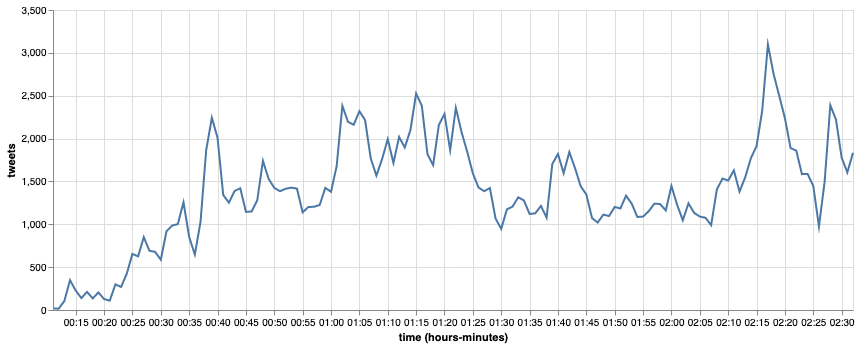

In [281]:
altair.Chart(dropped, width=800).mark_line().encode(x='hoursminutes(time):T', y='tweets:Q')

But maybe it would look better as an area chart to emphasize how much data was dropped? This involves a bit of reshaping of the data.

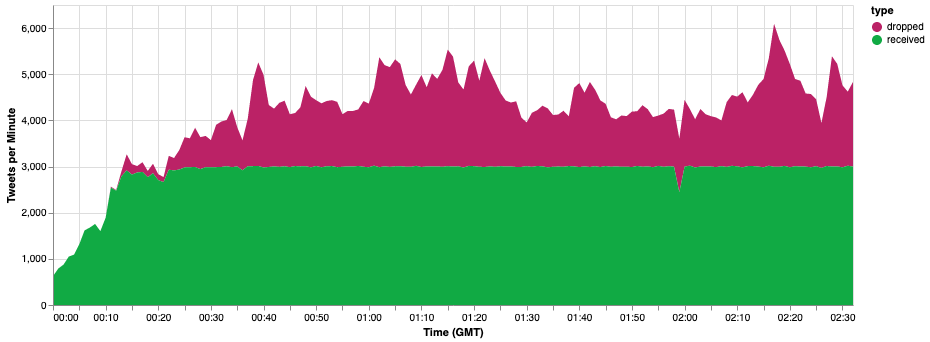

In [284]:
from altair import Chart, Scale, Color, Axis, X, Y, Tooltip

demdebate2 = pandas.concat([
    pandas.DataFrame({'time': dropped['time'], 'tweets': dropped['tweets'], 'type': 'dropped'}),
    pandas.DataFrame({'time': demdebate['time'], 'tweets': demdebate['tweets'], 'type': 'received'})
])

Chart(demdebate2, width=800).mark_area().encode(
    X("hoursminutes(time):T", axis=Axis(title="Time (GMT)")),
    Y("tweets:Q", axis=Axis(title="Tweets per Minute")),
    Color('type:N',
        scale=Scale(domain=['dropped', 'received'],range=['#BB2266', '#11AA44'])
    ),
    Tooltip(['tweets', 'hoursminutes(time)'])
    
)